In [1]:
import pandas as pd
import pickle
from modules.process_data import *
from modules.utils import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scanpy as sc
from tqdm import tqdm
from modules.dea import *
scaler = StandardScaler()

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-08 19:54:25.290595: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-08 19:54:25.854318: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Import data

In [2]:
dataset = "run"
#dataset = 'scdi'

In [3]:
if dataset == "run":
    adata1 = anndata.read_h5ad("data/A_count.h5ad")
    adata1.obs['Sample_Tag'] = 'LD_5xFAD'
    adata2 = anndata.read_h5ad("data/B_count.h5ad")
    adata2.obs['Sample_Tag'] = 'LD_NC'
    adata = anndata.concat([adata1, adata2], axis=0)
    anno_df1 = pd.read_csv("data/A_mapping.csv", skiprows=4)
    anno_df2 = pd.read_csv("data/B_mapping.csv", skiprows=4)
    anno_df = pd.concat([anno_df1, anno_df2])
    
    tag1 = 'LD_NC'
    tag2 = 'LD_5xFAD'
    
elif dataset == "scdi":
    adata = anndata.read_h5ad("data/fede_count.h5ad")
    anno_df = pd.read_csv("data/fede_mapping.csv", skiprows=4)
    
    tag1 = 'SampleTag17_flex'
    tag2 = 'SampleTag18_flex'

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# Process data

In [4]:
adata = rm_high_mt(adata, threshold=1)
adata = filter_cells_by_gene_counts(adata)
adata = rm_low_exp(adata, threshold=0.1)
sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
#join sample tag to df
sc_df = pd.DataFrame(adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X, index=adata.obs_names, columns=adata.var_names)
sample_tags = pd.DataFrame(adata.obs.Sample_Tag)
sc_df = sc_df.join(sample_tags)

In [6]:
#drop multiplets and undetermined
sc_df = sc_df[~sc_df['Sample_Tag'].isin(['Multiplet', 'Undetermined'])]

In [7]:
#creating annotation df
anno_df = anno_df.set_index('cell_id')[['class_name', "subclass_name", "supertype_name", 'cluster_name']]

In [8]:
#ensure index is type int
sc_df.index = sc_df.index.astype('int64')
anno_df.index = anno_df.index.astype('int64')

In [9]:
#merge expression matrix and annotation
sc_df = sc_df.join(anno_df)

# Select conditions to analyze

In [10]:
#extract sample tag data
sc_df1 = sc_df[sc_df['Sample_Tag'].isin([tag1])]
sc_df2 = sc_df[sc_df['Sample_Tag'].isin([tag2])]

In [ ]:
#extract specific type
sc_df1 = sc_df1[sc_df1['class_name'].isin(['30 Astro-Epen'])]
sc_df2 = sc_df2[sc_df2['class_name'].isin(['30 Astro-Epen'])]

# Type analysis

In [ ]:
X1 = sc_df1.drop(['Sample_Tag', 'class_name', "subclass_name", "supertype_name", 'cluster_name'], axis=1).values
Y1 = sc_df1['class_name'].values
#Y1 = sc_df1['cluster_name'].values

In [ ]:
X2 = sc_df2.drop(['Sample_Tag', 'class_name', "subclass_name", "supertype_name", 'cluster_name'], axis=1).values
Y2 = sc_df2['class_name'].values
#Y2 = sc_df2['cluster_name'].values

In [ ]:
unique_targets = [x for x in Counter(np.concatenate([Y1, Y2])).keys()]
palette = sns.color_palette('Set3', 12) + sns.color_palette('Paired', 12) + sns.color_palette('Set2', 10)
color_mapping = {target: palette[i] for i, target in enumerate(unique_targets)}

In [ ]:
components = 17
pca = PCA(n_components=components)

In [ ]:
X1 = scaler.fit_transform(X1)
X2 = scaler.fit_transform(X2)
X1_pca = pca.fit_transform(X1)
X2_pca = pca.fit_transform(X2)

In [ ]:
n_neighbors_list = [50, 75, 100]
plot_umaps(X1_pca, Y1, n_neighbors_list, color_mapping, min_count=100, classes_to_plot=None)
plot_umaps(X2_pca, Y2, n_neighbors_list, color_mapping, min_count=100, classes_to_plot=None)

In [ ]:
#umap
umap = UMAP(n_neighbors=100, n_components=2, n_jobs=-1)
X1_umap = umap.fit_transform(X1_pca)
X2_umap = umap.fit_transform(X2_pca)

In [ ]:
plot_umap(X1_umap, Y1, color_mapping, min_count=100, classes_to_plot=None)

In [ ]:
plot_umap(X2_umap, Y2, color_mapping, min_count=100, classes_to_plot=None)

# Differential expression analysis

In [11]:
sc_df1 = sc_df1.drop(['Sample_Tag', 'class_name', "subclass_name", "supertype_name", 'cluster_name'], axis=1)
sc_df2 = sc_df2.drop(['Sample_Tag', 'class_name', "subclass_name", "supertype_name", 'cluster_name'], axis=1)

In [12]:
#DEA
results_df = differential_expression_analysis(sc_df1, sc_df2)

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
100%|████████████████████████████████████| 22835/22835 [02:36<00:00, 145.64it/s]


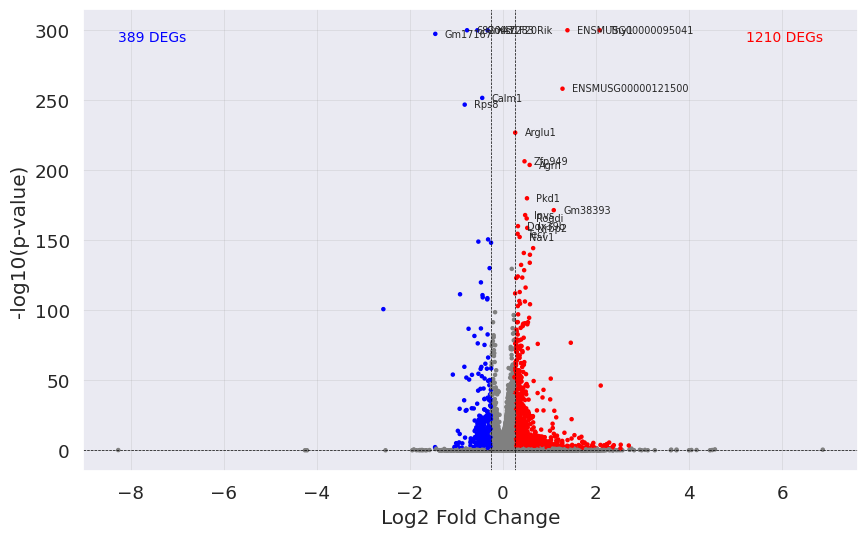

In [122]:
#volcano_plot
significant = get_volcano_plot(results_df, min_fold_change=0.25, max_p_value=0.05)

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


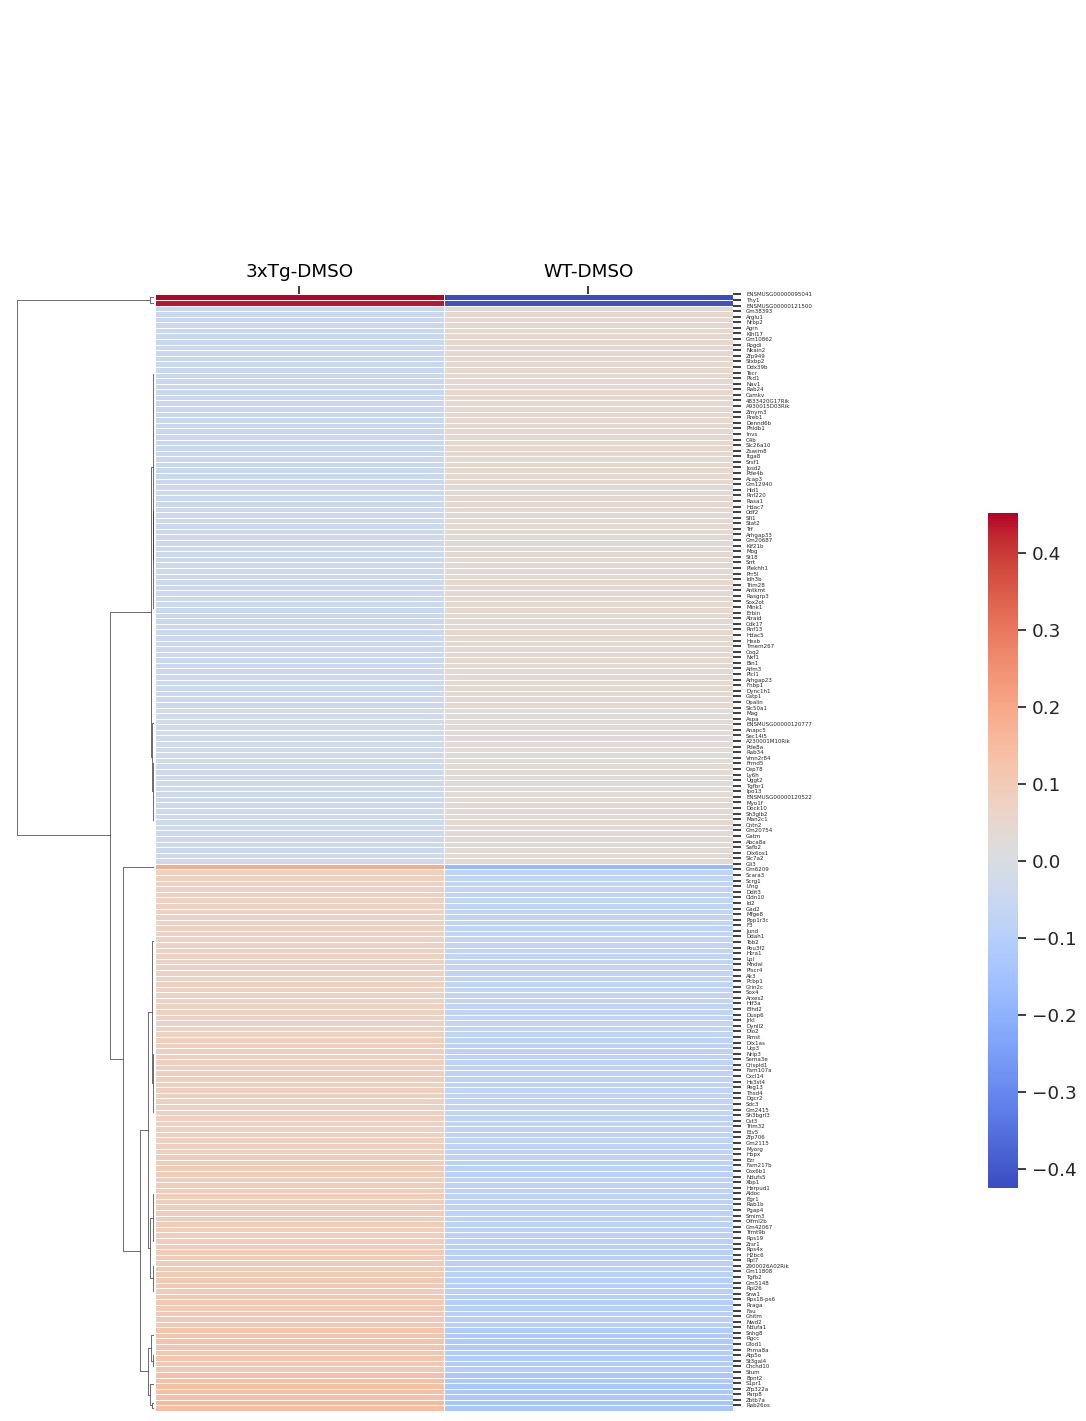

In [63]:
get_heatmap(results_df, sc_df1, sc_df2)

# GO enrichment analysis

In [64]:
dump_deg(results_df)

,gene,log2foldchange,pval,pval_corrected,log10pval_corrected
0,0610005C13Rik,-0.552996,9.797271e-01,9.998394e-01,0.000070
1,0610006L08Rik,-0.064522,8.777638e-01,9.998394e-01,0.000070
2,0610009B22Rik,-0.191837,7.391987e-01,9.998394e-01,0.000070
3,0610009E02Rik,-0.118037,3.764883e-02,9.694531e-02,1.013473
4,0610009L18Rik,0.163685,9.923104e-02,2.301382e-01,0.638011
...,...,...,...,...,...
22830,mt-Nd3,-0.065803,1.137413e-10,8.704032e-10,9.060280
22831,mt-Nd4,0.193207,5.737544e-03,1.744565e-02,1.758313
22832,mt-Nd4l,0.342815,9.404112e-01,9.998394e-01,0.000070
22833,mt-Nd5,0.363807,9.269427e-01,9.998394e-01,0.000070


In [74]:
#process_df_and_plot('DEG/analysis(21).txt')

In [75]:
#process_df_and_plot('DEG/analysis(20).txt')

In [ ]:
objanno = Gene2GoReader("/path/to/gene2go", taxids=[10090])

In [95]:
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.test_data.genes_NCBI_10090_ProteinCoding import GENEID2NT as MOUSE_GENEID2NT
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

def perform_go_enrichment(gene_list, background_genes):
    # Load the GO DAG
    obodag = GODag("DEG/go-basic.obo")

    # Load the gene to GO mapping for mouse
    objanno = Gene2GoReader("DEG/gene2go", taxids=[10090])

    # Get the namespace2association for mouse
    ns2assoc = objanno.get_ns2assc()

    # Create a GOEA object
    goeaobj = GOEnrichmentStudyNS(
        background_genes, # Background gene set
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh'] # defult multipletest correction method
    )

    # Run the GOEA and get significant results
    goea_results_all = goeaobj.run_study(gene_list)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]

    # Convert the results to a DataFrame
    df_results = pd.DataFrame([r.__dict__ for r in goea_results_sig])

    return df_results

In [149]:
positive_deg = results_df[(results_df["pval_corrected"] < 0.05) & (results_df["log2foldchange"] > 0.25)]['gene'].tolist()
#positive_deg = [x.upper() for x in positive_deg]

negative_deg = results_df[(results_df["pval_corrected"] < 0.05) & (results_df["log2foldchange"] <= -0.25)]['gene'].tolist()
#negative_deg = [x.upper() for x in negative_deg]

In [150]:
reference_list = [x.upper() for x in sc_df1.columns.values.tolist()]
reference_list = [x for x in sc_df1.columns.values.tolist()]

In [158]:
import mygene

# Initialize MyGene.info
mg = mygene.MyGeneInfo()

# Example gene list
gene_symbols = positive_deg

# Query MyGene.info to get NCBI Gene IDs
gene_info = mg.querymany(gene_symbols, scopes='symbol', fields='entrezgene', species='mouse')

# Extract NCBI Gene IDs
gene_list_ncbi = [entry.get('entrezgene') for entry in gene_info if 'entrezgene' in entry]

# Repeat for background genes if they are also in string format
background_genes_symbols = reference_list
background_gene_info = mg.querymany(background_genes_symbols, scopes='symbol', fields='entrezgene', species='mouse')
background_genes_ncbi = [entry.get('entrezgene') for entry in background_gene_info if 'entrezgene' in entry]

36 input query terms found dup hits:	[('1700056N10Rik', 2), ('2900052L18Rik', 2), ('4930447M23Rik', 2), ('4930467D21Rik', 2), ('9230109A2
27 input query terms found no hit:	['2810410L24Rik', '4931428F04Rik', 'Acpp', 'Ddx58', 'ENSMUSG00000095041', 'ENSMUSG00000120224', 'ENS


Original gene symbols: ['1300002E11Rik', '1500015L24Rik', '1700030K09Rik', '1700047M11Rik', '1700056N10Rik', '1700109H08Rik', '1700124L16Rik', '2410002F23Rik', '2510009E07Rik', '2810410L24Rik', '2810429I04Rik', '2900005J15Rik', '2900052L18Rik', '4833420G17Rik', '4930447M23Rik', '4930467D21Rik', '4930500H12Rik', '4930509J09Rik', '4930581F22Rik', '4931428F04Rik', '4933412O06Rik', '4933439C10Rik', '9230109A22Rik', '9430038I01Rik', '9930111J21Rik2', 'A230001M10Rik', 'A230056P14Rik', 'A230077H06Rik', 'A330015K06Rik', 'A330049N07Rik', 'A530046M15Rik', 'A630001G21Rik', 'A730011C13Rik', 'A930015D03Rik', 'AU020206', 'AU022754', 'Aaas', 'Aars2', 'Aatk', 'Abca2', 'Abca4', 'Abca8a', 'Abca8b', 'Abca9', 'Abcb1b', 'Abcb6', 'Abcd1', 'Abcg2', 'Abi3', 'Abl1', 'Acap3', 'Acat2', 'Accs', 'Acd', 'Acpp', 'Acr', 'Actn2', 'Acy1', 'Adam18', 'Adamts10', 'Adamts18', 'Adamtsl4', 'Adap1', 'Adap2', 'Adgrg4', 'Adipor2', 'Adrm1', 'Afap1l1', 'Afg3l1', 'Afm', 'Agap2', 'Agbl5', 'Agrn', 'Aifm3', 'Aim2', 'Aldh18a1', 'Aldh1

2053 input query terms found dup hits:	[('0610006L08Rik', 2), ('1010001B22Rik', 2), ('1100001I12Rik', 2), ('1110002J07Rik', 2), ('1110013H1
1186 input query terms found no hit:	['0610009B22Rik', '0610012G03Rik', '1110017D15Rik', '1110032A03Rik', '1190007I07Rik', '1520401A03Rik


Original background gene symbols: ['0610005C13Rik', '0610006L08Rik', '0610009B22Rik', '0610009E02Rik', '0610009L18Rik', '0610010K14Rik', '0610012G03Rik', '0610030E20Rik', '0610038B21Rik', '0610040B10Rik', '0610040F04Rik', '0610040J01Rik', '0610043K17Rik', '1010001B22Rik', '1100001I12Rik', '1110002E22Rik', '1110002J07Rik', '1110002L01Rik', '1110004F10Rik', '1110006O24Rik', '1110013H19Rik', '1110015O18Rik', '1110017D15Rik', '1110018N20Rik', '1110019D14Rik', '1110020A21Rik', '1110028F18Rik', '1110032A03Rik', '1110032F04Rik', '1110035H17Rik', '1110038B12Rik', '1110038F14Rik', '1110046J04Rik', '1110059E24Rik', '1110059G10Rik', '1110065P20Rik', '1190005I06Rik', '1190007I07Rik', '1190028D05Rik', '1300002E11Rik', '1300014J16Rik', '1500002C15Rik', '1500002F19Rik', '1500004A13Rik', '1500009L16Rik', '1500011B03Rik', '1500012K07Rik', '1500015A07Rik', '1500015L24Rik', '1500026H17Rik', '1500032F14Rik', '1500035N22Rik', '1520401A03Rik', '1600002D24Rik', '1600010M07Rik', '1600012H06Rik', '1600014C10Ri

In [161]:
len(background_genes_ncbi)

20000

In [160]:
len(gene_list_ncbi)

1162

In [162]:
df_results = perform_go_enrichment(gene_list_ncbi, background_genes_ncbi)

DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:40.711107 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 
Namespace associations:
Namespace: MF, Associations: 17776
Gene: 11287, GO Terms: {'GO:0030414', 'GO:0044877', 'GO:0048403', 'GO:0004867', 'GO:0002020', 'GO:0048406', 'GO:0004866'}
Gene: 11298, GO Terms: {'GO:0016746', 'GO:0016740', 'GO:0004060', 'GO:0071889', 'GO:0004059', 'GO:0016747'}
Gene: 11302, GO Terms: {'GO:0004713', 'GO:0004674', 'GO:0000166', 'GO:0005524', 'GO:0016740', 'GO:0016301', 'GO:0004672'}
Gene: 11303, GO Terms: {'GO:0019905', 'GO:0005524', 'GO:0031210', 'GO:0008320', 'GO:0140326', 'GO:0051117', 'GO:0031267', 'GO:0005548', 'GO:0120020', 'GO:0140328', 'GO:0008035', 'GO:0005102', 'GO:0000166', 'GO:0090556', 'GO:0034185', 'GO:0042626', 'GO:0090554', 'GO:0034186', 'GO:0005515', 'GO:0046623', 'GO:0034188', 'GO:0016887', 'GO:0140359'}
Gene: 11304, GO Terms: {'GO:0005503', 'GO:0000166', 'GO:0005502', 'GO:0005524', 'GO:0090555',